In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
import sklearn
from sklearn import linear_model
from scipy.optimize import curve_fit
import seaborn as sns
import vtk.util.numpy_support as numpy_support
from tvtk.api import tvtk, write_data
from tqdm import tqdm

import pickle
import glob
import os
import shutil

In [47]:
class OVFArray:
    def __init__(self, filepath:str, x:int, y:int, z:int, msat:float, *args):
        self.filepath = filepath
        self.x = x
        self.y = y
        self.z = z
        self.size = (x,y,z)
        self.msat = msat
        self.read_files()
        if args:
            start,stop,step = args
            if stop > 0:
                self.field = np.arange(start,stop +1,step)
            else:
                self.field = np.arange(start,stop-1,step)

    def read_files(self) -> None:
        def parse_data(df,zlen,xlen,ylen):
            end = -2
            for index,row in df.iterrows():
                if row['# OOMMF: rectangular mesh v1.0'] == '# Begin: Data Text':
                    start = index + 1
                    break
            df_vec = df.iloc[start:end]
            df_vec[['x','y','z']] = df_vec['# OOMMF: rectangular mesh v1.0'].str.split(n=3,expand = True)
            new_df = df_vec.loc[:,('x','y','z')].astype(float)
            arr = new_df.to_numpy().reshape(zlen,xlen,ylen,3)
            return arr
        big_array = []
        filelist = glob.glob(self.filepath)
        filelist.sort()
        self.filelist = filelist
        for filename in tqdm(filelist):
            df = pd.read_csv(filename)
            big_array.append(parse_data(df,self.z,self.x,self.y))
        self.list = big_array
        
    def save_vectorfield(self, index:int , dataname:str, filename:str) -> None:
        vec_field = self.list[index]
        vx=vec_field[:,:,:,0]
        vy=vec_field[:,:,:,1]
        vz=vec_field[:,:,:,2]

        dim=vx.shape

        # Generate the grid
        xx,yy,zz=np.mgrid[0:dim[0],0:dim[1],0:dim[2]]
        pts = np.empty(vx.shape + (3,), dtype=int)
        pts[..., 0] = zz #swap xx and zz to ensure that the layers are shown properly. 
        pts[..., 1] = yy 
        pts[..., 2] = xx

        vectors = np.empty(vx.shape + (3,), dtype=float)
        vectors[..., 0] = vx 
        vectors[..., 1] = vy
        vectors[..., 2] = vz 

        # We reorder the points and vectors so this is as per VTK's
        # requirement of x first, y next and z last.
        pts = pts.transpose(2, 1, 0, 3).copy()
        pts.shape = pts.size // 3, 3

        vectors = vectors.transpose(2, 1, 0, 3).copy()
        vectors.shape = vectors.size // 3, 3

        sg = tvtk.StructuredGrid(dimensions=xx.shape, points=pts)

        sg.point_data.vectors = vectors
        sg.point_data.vectors.name = dataname

        write_data(sg, filename)
    
    def magnetise(self) -> list: #Just calculate the magnetisation in the z-direction
        big_array = []
        def magnetisation(arr,msat):
            z_num,x_num,y_num,_ = arr.shape
            summed = z_num * x_num * y_num
            z = np.sum(arr[:2,:,:,2])/2
            return z*msat/summed
        for arr in self.list:
            big_array.append(magnetisation(arr,self.msat))
        self.magnetisation = big_array
        return big_array
    
    def plot_slice(self,index:int, sliced:int): ###Outputs an image 
        c = 'afmhot'
        arr = self.list[index]
        fig,ax = plt.subplots(1,3,figsize=(14, 12))
        im = ax[0].imshow(arr[sliced,:,:,0],cmap = c) ### Set the equals here so that you can reference it for the colorbar
        ax[1].imshow(arr[sliced,:,:,1],cmap = c)
        ax[2].imshow(arr[sliced,:,:,2],cmap = c)
        labels = ['x','y','z']
        for i in range(3):
            ax[i].set_title(f'Magnetisation in {labels[i]} direction')
        plt.suptitle(f'Index {index} Slice {sliced+1}',fontsize = 16)
        fig.subplots_adjust(top=1.45)
        cax = plt.axes([0.95, 0.6, 0.045, 0.35]) 
        plt.colorbar(im,cax = cax)
        plt.show()
        
    def save_object(self, filename):
        with open(filename, 'wb') as outp:  # Overwrites any existing file.
            pickle.dump(self, outp, pickle.HIGHEST_PROTOCOL)

In [4]:
highT2206 = OVFArray('/Users/pheeyonghan/Desktop/Research/Skyrmion/Micromag.tmp/220601/220601.out/*highT*.ovf',512,512,10,1e6,300,-400,-5)

100%|█████████████████████████████████████████| 141/141 [11:35<00:00,  4.93s/it]


In [5]:
lowT2206 = OVFArray('/Users/pheeyonghan/Desktop/Research/Skyrmion/Micromag.tmp/220601/220601.out/*lowT*.ovf',512,512,10,1e6,300,-400,-5)

100%|█████████████████████████████████████████| 141/141 [27:56<00:00, 11.89s/it]


### Loading files

In [48]:
### Load files
with open('/Users/pheeyonghan/Desktop/Research/Skyrmion/Micromag.tmp/220601/pickle/lowT2206', 'rb') as pickle_file:
    lowT2206 = pickle.load(pickle_file)
with open('/Users/pheeyonghan/Desktop/Research/Skyrmion/Micromag.tmp/220601/pickle/highT2206', 'rb') as pickle_file:
    highT2206 = pickle.load(pickle_file)

In [49]:
high_mag = highT2206.magnetise()
low_mag = lowT2206.magnetise()

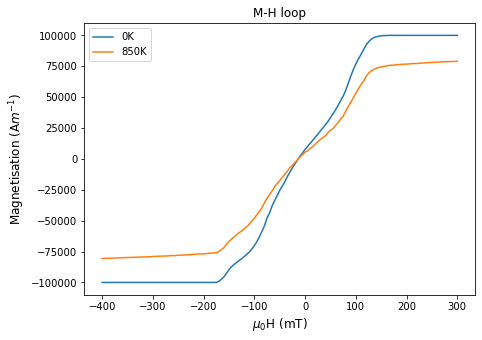

In [50]:
plt.subplots(1,1,figsize = (7,5))
plt.plot(lowT2206.field,lowT2206.magnetisation, label = '0K')
plt.plot(lowT2206.field,highT2206.magnetisation, label = '850K')
plt.title('M-H loop',fontsize = 'large')
plt.xlabel('$\mu_0$H (mT)',fontsize = 'large')
plt.ylabel('Magnetisation (A$m^{-1}$)',fontsize = 'large')
plt.legend()
plt.show()

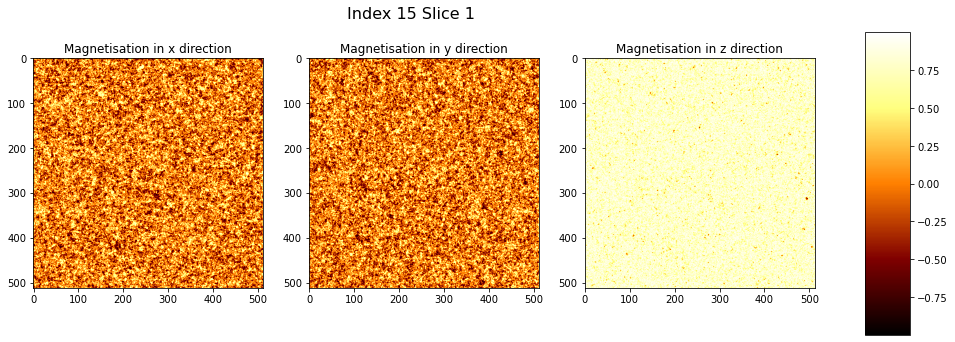

In [55]:
highT2206.plot_slice(15,0)
